Particle Size Predict model

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

#############################################
# 고정된 시드 설정 (재현성 확보)
#############################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

#############################################
# 1. 데이터 정의 - 상황에 맞게 설정가능합니다.
#    (particle_size, pressure) 2차원 조합
#############################################
particle_sizes = [10, 9, 8, 7, 6, 5, 4, 3, 1.5]  # 9 개 
pressures = [0.1, 0.3, 0.5, 0.7, 0.9, 1, 2, 3, 4, 5,
             6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
             16, 17, 18, 19, 20, 21, 22, 23, 24, 25] #30 개

# X_list에 모든 (ps, pr) 조합을 순서대로 저장
X_list = []
for ps in particle_sizes:
    for pr in pressures:
        X_list.append((ps, pr))

# numpy 배열로 변환 -> shape = (270, 2)
X_train = np.array(X_list)

# 이제 X_train[i] = (particle_size, pressure)에 대응하는
# stress, strain 데이터를 준비해야 함 (길이: 9 X 30 = 270).

true_stress = [0.42395, 1.3172, 2.2183, 3.1395, 4.0532, 4.5485, 8.8582, 12.108, 14.62, 16.46, 17.736, 18.629, 19.662, 21.146, 23.647, 27.479, 33.616, 40.502, 46.2, 51.445, 57.572, 70.516, 83.191, 91.036, 93.565, 93.427, 92.186, 90.471, 88.628, 86.706, 0.40464, 1.255, 2.1451, 3.0499, 3.9641, 4.4527, 8.4044, 11.41, 13.806, 15.615, 16.904, 17.96, 18.977, 20.264, 22.063, 24.496, 27.909, 31.943, 36.064, 40.094, 48.633, 63.989, 80.934, 95.109, 103, 105.26, 104.69, 102.67, 100.74, 99.362, 0.39807, 1.2208, 2.0766, 2.9888, 3.8777, 4.2589, 7.9809, 10.839, 13.013, 14.676, 16.024, 17.113, 18.085, 19.21, 20.48, 22.199, 24.358, 27.187, 30.114, 33.271, 37.354, 46.009, 61.447, 78.111, 91.517, 99.36, 101.4, 98.874, 95.619, 91.888, 0.37806, 1.1728, 1.9926, 2.7955, 3.6207, 4.0067, 7.3584, 9.9018, 11.969, 13.594, 14.957, 16.04, 17.003, 18.092, 19.263, 20.701, 22.594, 25.065, 27.783, 30.409, 33.273, 36.91, 45.3, 59.338, 75.585, 89.447, 99.494, 103.64, 103.13, 99.684, 0.35253, 1.0856, 1.8337, 2.5634, 3.2648, 3.5943, 6.5101, 9.014, 10.975, 12.49, 13.719, 14.689, 15.565, 16.5, 17.468, 18.543, 19.846, 21.591, 24, 27.267, 31.08, 35.381, 39.328, 43.591, 49.265, 56.858, 64.081, 68.924, 70.108, 68.926, 0.3334, 1.0312, 1.7362, 2.3775, 3.036, 3.3408, 5.8582, 8.0595, 9.7577, 11.17, 12.369, 13.306, 14.171, 15.02, 15.943, 16.849, 17.822, 18.899, 20.753, 22.967, 25.916, 29.35, 33.009, 37.398, 42.048, 47.551, 54.859, 63.95, 72.333, 78.366, 0.30786, 0.95632, 1.6298, 2.1925, 2.7215, 2.9909, 5.0986, 6.9557, 8.4146, 9.6988, 10.749, 11.638, 12.538, 13.338, 14.146, 14.909, 15.688, 16.571, 17.66, 19.054, 20.896, 23.379, 26.247, 29.753, 34.009, 38.871, 44.993, 52.96, 62.294, 71.82, 0.269, 0.85005, 1.3947, 1.8753, 2.2807, 2.4858, 4.2505, 5.7477, 6.9658, 7.9934, 8.9578, 9.721, 10.523, 11.236, 11.878, 12.544, 13.164, 13.81, 14.669, 15.768, 17.174, 19.04, 21.469, 24.374, 27.856, 32.055, 36.389, 41.252, 46.322, 51.766, 0.20297, 0.62202, 0.96619, 1.2384, 1.4941, 1.6143, 2.6512, 3.4933, 4.2135, 4.8844, 5.4456, 6.0013, 6.5029, 6.9804, 7.4618, 7.8873, 8.3335, 8.8678, 9.2436, 9.7543, 10.298, 10.896, 11.604, 12.439, 13.432, 14.692, 15.983, 17.618, 19.605, 21.782]
true_strain = [0.017925, 0.055025, 0.092575, 0.1299, 0.16615, 0.183775, 0.3472, 0.495375, 0.63895, 0.78445, 0.9379, 1.10445, 1.28925, 1.49745, 1.73625, 2.0115, 2.329, 2.6875, 3.071, 3.46075, 3.841, 4.2085, 4.558, 4.8665, 5.12425, 5.33525, 5.50775, 5.65575, 5.78775, 5.91, 0.017325, 0.053375, 0.09, 0.1261, 0.161175, 0.1783, 0.335225, 0.4762, 0.6115, 0.74785, 0.88975, 1.04175, 1.20775, 1.392225, 1.60025, 1.8365, 2.106, 2.4105, 2.74325, 3.08925, 3.44125, 3.78975, 4.14175, 4.487, 4.8075, 5.097, 5.3415, 5.547, 5.718, 5.862, 0.016625, 0.0514, 0.086825, 0.121525, 0.15525, 0.1716, 0.32075, 0.4536, 0.580225, 0.70655, 0.83685, 0.974325, 1.122375, 1.284525, 1.46395, 1.66525, 1.892, 2.1465, 2.4285, 2.72775, 3.036, 3.34925, 3.66725, 3.9915, 4.31675, 4.63425, 4.935, 5.2115, 5.45825, 5.66975, 0.01585, 0.0492, 0.0831, 0.1163, 0.148325, 0.163875, 0.3041, 0.427625, 0.54475, 0.660425, 0.7785, 0.9016, 1.032275, 1.17275, 1.32615, 1.494625, 1.6825, 1.8905, 2.12125, 2.37125, 2.6365, 2.9065, 3.184, 3.46475, 3.755, 4.04775, 4.34225, 4.63275, 4.91175, 5.1775, 0.01505, 0.04685, 0.079175, 0.110675, 0.140825, 0.1553, 0.2839, 0.397025, 0.50365, 0.60805, 0.7134, 0.822025, 0.936025, 1.057375, 1.18735, 1.328275, 1.4824, 1.652, 1.839, 2.04375, 2.263, 2.49325, 2.72775, 2.964, 3.20375, 3.44925, 3.7015, 3.95625, 4.2115, 4.4655, 0.014125, 0.0443, 0.0747, 0.104025, 0.131825, 0.145175, 0.2616, 0.363125, 0.4582, 0.5505, 0.64285, 0.736925, 0.834525, 0.93685, 1.04505, 1.160625, 1.2849, 1.41925, 1.56525, 1.7245, 1.897, 2.0815, 2.27375, 2.47125, 2.66825, 2.86675, 3.06875, 3.27375, 3.48375, 3.6965, 0.013125, 0.041425, 0.069725, 0.096425, 0.121375, 0.133275, 0.235325, 0.324225, 0.406475, 0.485975, 0.564725, 0.644175, 0.725625, 0.809525, 0.897375, 0.989525, 1.08715, 1.190825, 1.302, 1.421275, 1.54975, 1.68775, 1.8345, 1.9885, 2.1455, 2.304, 2.46425, 2.625, 2.7875, 2.95275, 0.01225, 0.0388, 0.064425, 0.0878, 0.1091, 0.119025, 0.205125, 0.279475, 0.347975, 0.413475, 0.477875, 0.5422, 0.607375, 0.67375, 0.74225, 0.813075, 0.88695, 0.9643, 1.04595, 1.132, 1.2236, 1.3211, 1.4248, 1.53425, 1.649, 1.76775, 1.88825, 2.00925, 2.1305, 2.252, 0.01105, 0.03315, 0.0514, 0.06705, 0.081025, 0.08755, 0.143425, 0.19055, 0.233625, 0.27455, 0.3143, 0.353475, 0.39255, 0.4318, 0.47155, 0.51195, 0.553375, 0.5959, 0.6398, 0.685275, 0.732525, 0.78175, 0.833175, 0.886925, 0.9432, 1.001725, 1.0627, 1.12525, 1.18895, 1.252675]


y_stress_train = np.array(true_stress)
y_strain_train = np.array(true_strain)

print(f"X_train shape: {X_train.shape}")         # (150, 2)
print(f"y_stress_train shape: {y_stress_train.shape}")   # (150,)
print(f"y_strain_train shape: {y_strain_train.shape}")   # (150,)

#############################################
# 2. Gaussian Process 모델 설정 & 학습
#############################################
kernel = C(1.0, (1e-3, 1e5)) * Matern(length_scale=5.0, nu=1.0) + WhiteKernel(noise_level=1e-5)

gpr_stress = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10,
    random_state=SEED
)
gpr_strain = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10,
    random_state=SEED
)

# 모델 학습
gpr_stress.fit(X_train, y_stress_train)
gpr_strain.fit(X_train, y_strain_train)

#############################################
# 3. 모델 평가 함수
#############################################
def evaluate_model(gp_model, X, y_true):
    y_pred, y_std = gp_model.predict(X, return_std=True)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2, y_pred, y_std

# (선택) 훈련 데이터에 대한 적합도 확인
stress_mse_train, stress_mae_train, stress_r2_train, stress_pred_train, stress_std_train = evaluate_model(
    gpr_stress, X_train, y_stress_train
)
strain_mse_train, strain_mae_train, strain_r2_train, strain_pred_train, strain_std_train = evaluate_model(
    gpr_strain, X_train, y_strain_train
)

print("========== GPR Model Performance on Training Data ==========")
print(f"Stress - R²: {stress_r2_train:.3f}, MSE: {stress_mse_train:.3f}, MAE: {stress_mae_train:.3f}")
print(f"Strain - R²: {strain_r2_train:.3f}, MSE: {strain_mse_train:.3f}, MAE: {strain_mae_train:.3f}")

#############################################
# 4. Bayesian Optimization
#    - 목적함수에서 Stress, Strain 모두 고려
#    - 제약(Stress < 45, Strain < 4) 위반 시 페널티
#############################################
def objective_function(particle_size, pressure):
    # 예측
    stress_pred = gpr_stress.predict([[particle_size, pressure]])[0]
    strain_pred = gpr_strain.predict([[particle_size, pressure]])[0]
    
    # 제약 조건
    penalty = 0.0
    if stress_pred >= 45:
        penalty -= 100.0 * (stress_pred - 45)
    if strain_pred >= 4:
        penalty -= 100.0 * (strain_pred - 4)
    
    # (예시) 목표: particle_size + pressure + penalty 최댓값
    base_value = particle_size + pressure
    return base_value + penalty

# 탐색 범위
pbounds = {
    'particle_size': (6, 20),  # 실제 particle_sizes 범위
    'pressure': (0.1, 25)     # 실제 pressures 범위
}

optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=random.randint(1, 1000)
)

optimizer.maximize(init_points=10, n_iter=30)

opt_params = optimizer.max['params']
optimal_particle_size = opt_params['particle_size']
optimal_pressure = opt_params['pressure']
optimal_value = optimizer.max['target']

# 최적해에서 Stress, Strain 예측
opt_stress = gpr_stress.predict([[optimal_particle_size, optimal_pressure]])[0]
opt_strain = gpr_strain.predict([[optimal_particle_size, optimal_pressure]])[0]

print("\n===== Optimization Result =====")
print(f"Optimal Particle Size: {optimal_particle_size:.4f}")
print(f"Optimal Pressure: {optimal_pressure:.4f}")
print(f"Optimal Objective Value: {optimal_value:.4f}")
print(f"Predicted Stress at Opt: {opt_stress:.4f}")
print(f"Predicted Strain at Opt: {opt_strain:.4f}")

#############################################
# 5. 각 Particle Size별로 
#    Pressure를 (0.1~25) 범위 세분화 → 제약 만족 + objective 최대 지점
#############################################
particle_size_candidates = [1.5, 5, 10, 15, 20 ]
pressure_candidates = np.linspace(0.1, 25, 300)  # 예: 300개로 분할 샘플링

print("\n===== Per Particle Size: Best Pressure under Constraints =====")
for ps in particle_size_candidates:
    best_objective = None
    best_pressure = None
    for pr in pressure_candidates:
        # 예측
        st = gpr_stress.predict([[ps, pr]])[0]
        stn = gpr_strain.predict([[ps, pr]])[0]
        # 제약조건 확인
        if (st < 45) and (stn < 4):
            # objective
            obj_val = objective_function(ps, pr)
            # 갱신
            if (best_objective is None) or (obj_val > best_objective):
                best_objective = obj_val
                best_pressure = pr
    
    if best_pressure is None:
        print(f"Particle Size={ps}: No feasible Pressure found (Constraints not satisfied).")
    else:
        # 최적해에서 Stress, Strain 확인
        st_opt = gpr_stress.predict([[ps, best_pressure]])[0]
        stn_opt = gpr_strain.predict([[ps, best_pressure]])[0]
        print(f"Particle Size={ps}")
        print(f"   Best Pressure={best_pressure:.4f}, Objective={best_objective:.4f}")
        print(f"   Stress={st_opt:.4f}, Strain={stn_opt:.4f}")


X_train shape: (270, 2)
y_stress_train shape: (270,)
y_strain_train shape: (270,)
========== GPR Model Performance on Training Data ==========
Stress - R²: 1.000, MSE: 0.000, MAE: 0.000
Strain - R²: 1.000, MSE: 0.000, MAE: 0.000
|   iter    |  target   | partic... | pressure  |
-------------------------------------------------
| 1         | -1.933e+0 | 8.801     | 17.22     |
| 2         | 22.64     | 19.07     | 3.57      |
| 3         | -5.064e+0 | 7.71      | 20.72     |
| 4         | -166.6    | 19.01     | 18.69     |
| 5         | 20.51     | 12.92     | 7.588     |
| 6         | 16.95     | 9.904     | 7.05      |
| 7         | -64.07    | 19.54     | 14.63     |
| 8         | 28.37     | 17.48     | 10.89     |
| 9         | 19.1      | 6.058     | 13.04     |
| 10        | 10.45     | 6.106     | 4.343     |
| 11        | 12.46     | 12.27     | 0.1897    |
| 12        | -288.9    | 19.99     | 24.98     |
| 13        | -76.26    | 12.09     | 12.78     |
| 14        | 6.321  

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

#############################################
# 고정된 시드 설정 (재현성 확보)
#############################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

#############################################
# 1. 기존 데이터 정의
#############################################
particle_sizes = [10, 9, 8, 7, 6, 5, 4, 3, 1.5]  # 9 개 
pressures = [
    0.1, 0.3, 0.5, 0.7, 0.9, 1, 2, 3, 4, 5,
    6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
    16, 17, 18, 19, 20, 21, 22, 23, 24, 25
] # 30 개

# X_list에 모든 (ps, pr) 조합을 순서대로 저장
X_list = []
for ps in particle_sizes:
    for pr in pressures:
        X_list.append((ps, pr))

X_train_original = np.array(X_list)  # shape = (9*30=270, 2)

# (주의) 아래 true_stress, true_strain 길이도 270개라고 가정
# 실제 코드 상으로는 270개가 맞는지 꼭 확인하세요.
true_stress = [
    0.42395, 1.3172, 2.2183, 3.1395, 4.0532, 4.5485, 8.8582, 12.108, 14.62, 16.46,
    17.736, 18.629, 19.662, 21.146, 23.647, 27.479, 33.616, 40.502, 46.2, 51.445,
    57.572, 70.516, 83.191, 91.036, 93.565, 93.427, 92.186, 90.471, 88.628, 86.706,
    0.40464, 1.255, 2.1451, 3.0499, 3.9641, 4.4527, 8.4044, 11.41, 13.806, 15.615,
    16.904, 17.96, 18.977, 20.264, 22.063, 24.496, 27.909, 31.943, 36.064, 40.094,
    48.633, 63.989, 80.934, 95.109, 103, 105.26, 104.69, 102.67, 100.74, 99.362,
    0.39807, 1.2208, 2.0766, 2.9888, 3.8777, 4.2589, 7.9809, 10.839, 13.013, 14.676,
    16.024, 17.113, 18.085, 19.21, 20.48, 22.199, 24.358, 27.187, 30.114, 33.271,
    37.354, 46.009, 61.447, 78.111, 91.517, 99.36, 101.4, 98.874, 95.619, 91.888,
    0.37806, 1.1728, 1.9926, 2.7955, 3.6207, 4.0067, 7.3584, 9.9018, 11.969, 13.594,
    14.957, 16.04, 17.003, 18.092, 19.263, 20.701, 22.594, 25.065, 27.783, 30.409,
    33.273, 36.91, 45.3, 59.338, 75.585, 89.447, 99.494, 103.64, 103.13, 99.684,
    0.35253, 1.0856, 1.8337, 2.5634, 3.2648, 3.5943, 6.5101, 9.014, 10.975, 12.49,
    13.719, 14.689, 15.565, 16.5, 17.468, 18.543, 19.846, 21.591, 24, 27.267, 31.08,
    35.381, 39.328, 43.591, 49.265, 56.858, 64.081, 68.924, 70.108, 68.926,
    0.3334, 1.0312, 1.7362, 2.3775, 3.036, 3.3408, 5.8582, 8.0595, 9.7577, 11.17,
    12.369, 13.306, 14.171, 15.02, 15.943, 16.849, 17.822, 18.899, 20.753, 22.967,
    25.916, 29.35, 33.009, 37.398, 42.048, 47.551, 54.859, 63.95, 72.333, 78.366,
    0.30786, 0.95632, 1.6298, 2.1925, 2.7215, 2.9909, 5.0986, 6.9557, 8.4146, 9.6988,
    10.749, 11.638, 12.538, 13.338, 14.146, 14.909, 15.688, 16.571, 17.66, 19.054,
    20.896, 23.379, 26.247, 29.753, 34.009, 38.871, 44.993, 52.96, 62.294, 71.82,
    0.269, 0.85005, 1.3947, 1.8753, 2.2807, 2.4858, 4.2505, 5.7477, 6.9658, 7.9934,
    8.9578, 9.721, 10.523, 11.236, 11.878, 12.544, 13.164, 13.81, 14.669, 15.768,
    17.174, 19.04, 21.469, 24.374, 27.856, 32.055, 36.389, 41.252, 46.322, 51.766,
    0.20297, 0.62202, 0.96619, 1.2384, 1.4941, 1.6143, 2.6512, 3.4933, 4.2135, 4.8844,
    5.4456, 6.0013, 6.5029, 6.9804, 7.4618, 7.8873, 8.3335, 8.8678, 9.2436, 9.7543,
    10.298, 10.896, 11.604, 12.439, 13.432, 14.692, 15.983, 17.618, 19.605, 21.782
]
true_strain = [
    0.017925, 0.055025, 0.092575, 0.1299, 0.16615, 0.183775, 0.3472, 0.495375, 0.63895,
    0.78445, 0.9379, 1.10445, 1.28925, 1.49745, 1.73625, 2.0115, 2.329, 2.6875, 3.071,
    3.46075, 3.841, 4.2085, 4.558, 4.8665, 5.12425, 5.33525, 5.50775, 5.65575, 5.78775,
    5.91, 0.017325, 0.053375, 0.09, 0.1261, 0.161175, 0.1783, 0.335225, 0.4762, 0.6115,
    0.74785, 0.88975, 1.04175, 1.20775, 1.392225, 1.60025, 1.8365, 2.106, 2.4105,
    2.74325, 3.08925, 3.44125, 3.78975, 4.14175, 4.487, 4.8075, 5.097, 5.3415, 5.547,
    5.718, 5.862, 0.016625, 0.0514, 0.086825, 0.121525, 0.15525, 0.1716, 0.32075,
    0.4536, 0.580225, 0.70655, 0.83685, 0.974325, 1.122375, 1.284525, 1.46395, 1.66525,
    1.892, 2.1465, 2.4285, 2.72775, 3.036, 3.34925, 3.66725, 3.9915, 4.31675, 4.63425,
    4.935, 5.2115, 5.45825, 5.66975, 0.01585, 0.0492, 0.0831, 0.1163, 0.148325, 0.163875,
    0.3041, 0.427625, 0.54475, 0.660425, 0.7785, 0.9016, 1.032275, 1.17275, 1.32615,
    1.494625, 1.6825, 1.8905, 2.12125, 2.37125, 2.6365, 2.9065, 3.184, 3.46475, 3.755,
    4.04775, 4.34225, 4.63275, 4.91175, 5.1775, 0.01505, 0.04685, 0.079175, 0.110675,
    0.140825, 0.1553, 0.2839, 0.397025, 0.50365, 0.60805, 0.7134, 0.822025, 0.936025,
    1.057375, 1.18735, 1.328275, 1.4824, 1.652, 1.839, 2.04375, 2.263, 2.49325, 2.72775,
    2.964, 3.20375, 3.44925, 3.7015, 3.95625, 4.2115, 4.4655, 0.014125, 0.0443, 0.0747,
    0.104025, 0.131825, 0.145175, 0.2616, 0.363125, 0.4582, 0.5505, 0.64285, 0.736925,
    0.834525, 0.93685, 1.04505, 1.160625, 1.2849, 1.41925, 1.56525, 1.7245, 1.897,
    2.0815, 2.27375, 2.47125, 2.66825, 2.86675, 3.06875, 3.27375, 3.48375, 3.6965,
    0.013125, 0.041425, 0.069725, 0.096425, 0.121375, 0.133275, 0.235325, 0.324225,
    0.406475, 0.485975, 0.564725, 0.644175, 0.725625, 0.809525, 0.897375, 0.989525,
    1.08715, 1.190825, 1.302, 1.421275, 1.54975, 1.68775, 1.8345, 1.9885, 2.1455,
    2.304, 2.46425, 2.625, 2.7875, 2.95275, 0.01225, 0.0388, 0.064425, 0.0878, 0.1091,
    0.119025, 0.205125, 0.279475, 0.347975, 0.413475, 0.477875, 0.5422, 0.607375,
    0.67375, 0.74225, 0.813075, 0.88695, 0.9643, 1.04595, 1.132, 1.2236, 1.3211,
    1.4248, 1.53425, 1.649, 1.76775, 1.88825, 2.00925, 2.1305, 2.252, 0.01105, 0.03315,
    0.0514, 0.06705, 0.081025, 0.08755, 0.143425, 0.19055, 0.233625, 0.27455, 0.3143,
    0.353475, 0.39255, 0.4318, 0.47155, 0.51195, 0.553375, 0.5959, 0.6398, 0.685275,
    0.732525, 0.78175, 0.833175, 0.886925, 0.9432, 1.001725, 1.0627, 1.12525, 1.18895,
    1.252675
]

y_stress_train_original = np.array(true_stress)
y_strain_train_original = np.array(true_strain)

print(f"X_train_original shape: {X_train_original.shape}")  
print(f"y_stress_train_original shape: {y_stress_train_original.shape}")
print(f"y_strain_train_original shape: {y_strain_train_original.shape}")

#############################################
# 2. 추가 데이터 생성 (pressure 0.1 ~ 13)
#    - 실제 사용 시, 아래 '임의 생성' 대신
#      실측/레퍼런스 데이터를 넣어주세요.
#############################################

# (예시) 같은 Particle Size 목록을 사용한다고 가정
additional_particle_sizes = [15, 20]

# (예시) 0.1 ~ 13 사이를 50개로 나눠 샘플링
additional_pressures = [0.1, 0.3, 0.5, 0.7, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

X_list_additional = []
for ps in additional_particle_sizes:
    for pr in additional_pressures:
        X_list_additional.append((ps, pr))
X_train_additional = np.array(X_list_additional)

# --------------------------------
# (매우 중요) Stress/Strain "새로운 참값"이 있어야 학습이 가능
# 여기서는 예시로, 기존 데이터 범위를 참고하여 임의로 생성합니다.
# 실제로는 사용자분께서 "실험" 또는 "시뮬레이션"으로 얻은 데이터를
# 정확히 채워넣으셔야 합니다.
# --------------------------------
# 예: 임의로 "기존 y_stress_train의 평균 ± 랜덤 노이즈" 형태
# ========== (사용자 입력) 추가 Stress/Strain ==========
# 만약 40개가 아니라면 코드가 에러 납니다. 꼭 일치하도록 주의하세요!

additional_stress = [0.40277,
1.2448,
2.1911,
3.1745,
4.2348,
4.7844,
10.733,
15.103,
17.855,
19.487,
21.14,
23.775,
28.321,
37.041,
52.065,
74.071,
96.66,
113.45,
0.36389,
1.186,
2.1786,
3.307,
4.6127,
5.3546,
12.197,
17.3,
20.886,
23.75,
28.737,
41.35,
68.466,
110.77,
147.06,
160.17,
158.4,
150.19   
]
additional_strain = [0.0201,
0.061275,
0.10265,
0.143525,
0.183925,
0.203775,
0.39025,
0.56475,
0.741325,
0.930375,
1.14335,
1.3924,
1.69325,
2.0625,
2.5095,
3.003,
3.4705,
3.86225,
0.02095,
0.063175,
0.105575,
0.1473,
0.18845,
0.20835,
0.401625,
0.588625,
0.78615,
1.008875,
1.2785,
1.621,
2.0635,
2.57875,
3.03425,
3.35225,
3.58125,
3.77375  
]

y_stress_train_additional = np.array(additional_stress)
y_strain_train_additional = np.array(additional_strain)

print(f"y_stress_train_additional shape: {y_stress_train_additional.shape}")
print(f"y_strain_train_additional shape: {y_strain_train_additional.shape}")

#############################################
# 3. (기존 + 추가) 데이터 합치기
#############################################
X_train_combined = np.concatenate([X_train_original, X_train_additional], axis=0)
y_stress_train_combined = np.concatenate([y_stress_train_original, y_stress_train_additional], axis=0)
y_strain_train_combined = np.concatenate([y_strain_train_original, y_strain_train_additional], axis=0)

print(f"\nX_train_combined shape: {X_train_combined.shape}")
print(f"y_stress_train_combined shape: {y_stress_train_combined.shape}")
print(f"y_strain_train_combined shape: {y_strain_train_combined.shape}")

#############################################
# 4. Gaussian Process 설정 & 학습
#############################################
kernel = C(1.0, (1e-3, 1e5)) * Matern(length_scale=5.0, nu=1.0) + WhiteKernel(noise_level=1e-5)

gpr_stress = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=SEED)
gpr_strain = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=SEED)

# 추가 데이터 포함 재학습
gpr_stress.fit(X_train_combined, y_stress_train_combined)
gpr_strain.fit(X_train_combined, y_strain_train_combined)

#############################################
# 5. 모델 평가 함수
#############################################
def evaluate_model(gp_model, X, y_true):
    y_pred, y_std = gp_model.predict(X, return_std=True)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2, y_pred, y_std

# (선택) 훈련 데이터 전체에 대한 성능
stress_mse, stress_mae, stress_r2, stress_pred, stress_std = evaluate_model(
    gpr_stress, X_train_combined, y_stress_train_combined
)
strain_mse, strain_mae, strain_r2, strain_pred, strain_std = evaluate_model(
    gpr_strain, X_train_combined, y_strain_train_combined
)

print("\n========== GPR Model Performance on Combined Training Data ==========")
print(f"Stress - R²: {stress_r2:.3f}, MSE: {stress_mse:.3f}, MAE: {stress_mae:.3f}")
print(f"Strain - R²: {strain_r2:.3f}, MSE: {strain_mse:.3f}, MAE: {strain_mae:.3f}")

#############################################
# 6. Bayesian Optimization (동일)
#############################################
def objective_function(particle_size, pressure):
    stress_pred = gpr_stress.predict([[particle_size, pressure]])[0]
    strain_pred = gpr_strain.predict([[particle_size, pressure]])[0]
    
    # 예시 제약: Stress < 45, Strain < 4
    penalty = 0.0
    if stress_pred >= 45:
        penalty -= 100.0 * (stress_pred - 45)
    if strain_pred >= 4:
        penalty -= 100.0 * (strain_pred - 4)
    
    # (예시) 목표: particle_size + pressure + penalty 최댓값
    return (particle_size + pressure) + penalty

pbounds = {
    'particle_size': (1.5, 10),
    'pressure': (0.1, 25)
}

optimizer = BayesianOptimization(f=objective_function, pbounds=pbounds, random_state=SEED)
optimizer.maximize(init_points=5, n_iter=10)

opt_params = optimizer.max['params']
opt_ps = opt_params['particle_size']
opt_pr = opt_params['pressure']
opt_val = optimizer.max['target']

opt_stress = gpr_stress.predict([[opt_ps, opt_pr]])[0]
opt_strain = gpr_strain.predict([[opt_ps, opt_pr]])[0]

print("\n===== Optimization Result =====")
print(f"Optimal Particle Size: {opt_ps:.4f}")
print(f"Optimal Pressure: {opt_pr:.4f}")
print(f"Optimal Objective Value: {opt_val:.4f}")
print(f"Predicted Stress at Opt: {opt_stress:.4f}")
print(f"Predicted Strain at Opt: {opt_strain:.4f}")

#############################################
# 7. Particle Size별 Pressure 스캔
#############################################
particle_size_candidates = [1.5, 5, 10]
pressure_candidates = np.linspace(0.1, 25, 100)  # 100개 분할

print("\n===== Per Particle Size: Best Pressure under Constraints =====")
for ps in particle_size_candidates:
    best_obj = None
    best_pr = None
    for pr in pressure_candidates:
        st = gpr_stress.predict([[ps, pr]])[0]
        stn = gpr_strain.predict([[ps, pr]])[0]
        # 제약조건
        if (st < 45) and (stn < 4):
            obj_val = objective_function(ps, pr)
            if (best_obj is None) or (obj_val > best_obj):
                best_obj = obj_val
                best_pr = pr
    
    if best_pr is None:
        print(f"Particle Size={ps}: No feasible pressure found (constraint fail).")
    else:
        st_opt = gpr_stress.predict([[ps, best_pr]])[0]
        stn_opt = gpr_strain.predict([[ps, best_pr]])[0]
        print(f"Particle Size={ps}")
        print(f"   Best Pressure={best_pr:.4f}, Objective={best_obj:.4f}")
        print(f"   Stress={st_opt:.4f}, Strain={stn_opt:.4f}")

X_train_original shape: (270, 2)
y_stress_train_original shape: (270,)
y_strain_train_original shape: (270,)
y_stress_train_additional shape: (36,)
y_strain_train_additional shape: (36,)

X_train_combined shape: (306, 2)
y_stress_train_combined shape: (306,)
y_strain_train_combined shape: (306,)

========== GPR Model Performance on Combined Training Data ==========
Stress - R²: 1.000, MSE: 0.000, MAE: 0.000
Strain - R²: 1.000, MSE: 0.000, MAE: 0.000
|   iter    |  target   | partic... | pressure  |
-------------------------------------------------
| 1         | -2.376e+0 | 4.684     | 23.77     |
| 2         | 22.73     | 7.722     | 15.01     |
| 3         | 6.81      | 2.826     | 3.984     |
| 4         | 23.66     | 1.994     | 21.67     |
| 5         | 24.34     | 6.609     | 17.73     |
| 6         | 23.64     | 6.945     | 16.7      |
| 7         | 19.91     | 1.665     | 18.24     |
| 8         | 17.01     | 3.622     | 13.39     |
| 9         | 13.0      | 4.402     | 8.601   

## 그래프 plot (Line graph)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 사용자 정의 rc 설정
rc = plt.rc
rc('lines', lw=2)
rc('font', size=16)
rc('xtick', labelsize=18)
rc('xtick.major', size=5, width=3)
rc('ytick.major', size=5, width=3)
rc('legend', fontsize=15, frameon=False, loc='best')

### 굵은 Figure 경계 ###
def bold_figure_edge():
    figures = [x for x in plt._pylab_helpers.Gcf.get_all_fig_managers()]
    for figure in figures:
        for ax in figure.canvas.figure.get_axes():
            ax.spines['top'].set_linewidth(3)
            ax.spines['bottom'].set_linewidth(3)
            ax.spines['left'].set_linewidth(3)
            ax.spines['right'].set_linewidth(3)

def plot_pressure_vs_stress(
    particle_size_list,          # 여러 Particle Size 리스트
    gpr_stress,                  # 학습된 GPR(Stress) 모델
    X_train, y_stress_train,     # 원본 데이터(Train)
    p_min=0.1, p_max=25,         # Pressure 범위 (샘플링)
    n_points=200,
    xlim=(0, 25),
    ylim=(0, 90)                # (옵션) x축 범위 지정: 예: (0, 15)
):
    """
    여러 Particle Size에 대해 Pressure vs. Stress 그래프를
    한 Figure 위에 겹쳐 그리는 함수.
    - xlim 인자로 (xmin, xmax) 튜플을 주면 x축 범위를 그 값으로 설정
    """
    plt.figure(figsize=(8, 6))

    # Pressure 샘플링
    p_vals = np.linspace(p_min, p_max, n_points)

    # Particle Size 리스트 순회
    for ps in particle_size_list:
        # (A) GPR 예측 (ps, p_vals[i]) → stress_mean ± stress_std
        X_slice = np.column_stack([np.full_like(p_vals, ps), p_vals])
        stress_mean, stress_std = gpr_stress.predict(X_slice, return_std=True)

        # (B) 예측 곡선 & 불확실성 (alpha 값을 0.8로 수정)
        plt.plot(
            p_vals, stress_mean,
            label=f"Pred. Stress (ps={ps})",
            linewidth=2
        )
        plt.fill_between(
            p_vals,
            stress_mean - stress_std,
            stress_mean + stress_std,
            alpha=0.6  # 투명도를 낮춤 (불투명하게 표시)
        )

        # (C) 원본 데이터
        matching_idx = np.isclose(X_train[:, 0], ps, atol=0.01)
        orig_press = X_train[matching_idx, 1]
        orig_stress = y_stress_train[matching_idx]
        plt.scatter(
            orig_press, orig_stress,
            color='red', s=60, marker='o',
            alpha=0.8
        )

    # (D) Stress=45 수평선 (점선)
    plt.axhline(
        y=45, color='black', linestyle='--', linewidth=2, 
        label='Stress=45'
    )

    # (E) x축 및 y축 범위 지정 (옵션)
    if xlim is not None:
        plt.xlim(xlim)
        plt.ylim(ylim)

    # 그래프 꾸미기
    plt.grid(True, alpha=0.3)
    bold_figure_edge()
    plt.savefig("bayesian_optimization_stress_2.png", transparent=True)
    plt.show()


def plot_pressure_vs_strain(
    particle_size_list,
    gpr_strain,
    X_train, y_strain_train,
    p_min=0.1, p_max=25,
    n_points=200,
    xlim=(0, 25),
    ylim=(0, 6)                # (옵션) x축 범위 지정
):
    """
    여러 Particle Size에 대해 Pressure vs. Strain 그래프를
    한 Figure 위에 겹쳐 그리는 함수.
    - xlim 인자로 (xmin, xmax) 튜플을 주면 x축 범위를 그 값으로 설정
    """
    plt.figure(figsize=(8, 6))

    p_vals = np.linspace(p_min, p_max, n_points)

    for ps in particle_size_list:
        X_slice = np.column_stack([np.full_like(p_vals, ps), p_vals])
        strain_mean, strain_std = gpr_strain.predict(X_slice, return_std=True)

        plt.plot(
            p_vals, strain_mean,
            label=f"Pred. Strain (ps={ps})",
            linewidth=2
        )
        plt.fill_between(
            p_vals,
            strain_mean - strain_std,
            strain_mean + strain_std,
            alpha=0.8  # 투명도를 낮춤 (불투명하게 표시)
        )

        matching_idx = np.isclose(X_train[:, 0], ps, atol=0.01)
        orig_press = X_train[matching_idx, 1]
        orig_strain = y_strain_train[matching_idx]
        plt.scatter(
            orig_press, orig_strain,
            color='red', s=60, marker='o',
            alpha=1
        )

    # x축 범위 지정 (옵션)
    if xlim is not None:
        plt.xlim(xlim)
        plt.ylim(ylim)

    plt.grid(True, alpha=0.3)
    bold_figure_edge()
    plt.savefig("bayesian_optimization_strain_2.png", transparent=True)
    plt.show()


# -------------------------
# 사용 예시
# -------------------------
particle_size_list = [10]

# Stress 그래프
plot_pressure_vs_stress(
    particle_size_list=particle_size_list,
    gpr_stress=gpr_stress,
    X_train=X_train,
    y_stress_train=y_stress_train,
    p_min=0.1,
    p_max=25,
    n_points=200,
    xlim=(0, 25)
)

# Strain 그래프
plot_pressure_vs_strain(
    particle_size_list=particle_size_list,
    gpr_strain=gpr_strain,
    X_train=X_train,
    y_strain_train=y_strain_train,
    p_min=0.1,
    p_max=25,
    n_points=200,
    xlim=(0, 25)
)


NameError: name 'X_train' is not defined

## 그래프 plot (contour plot)

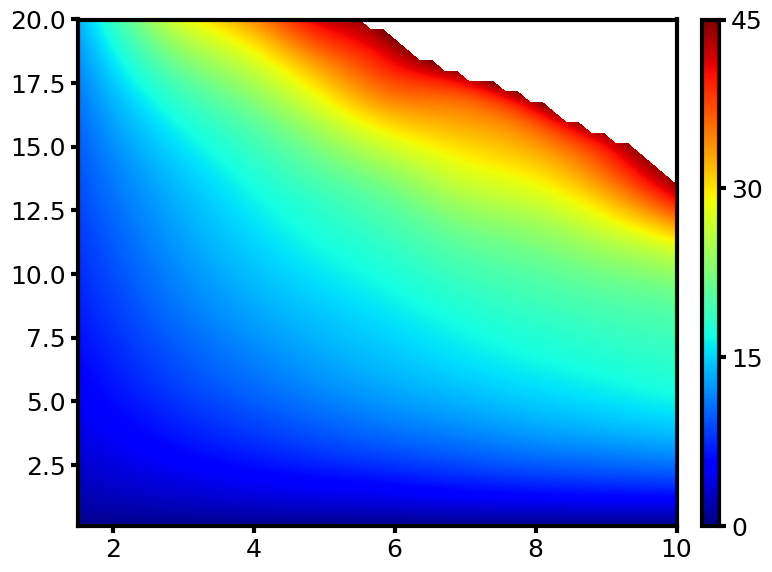

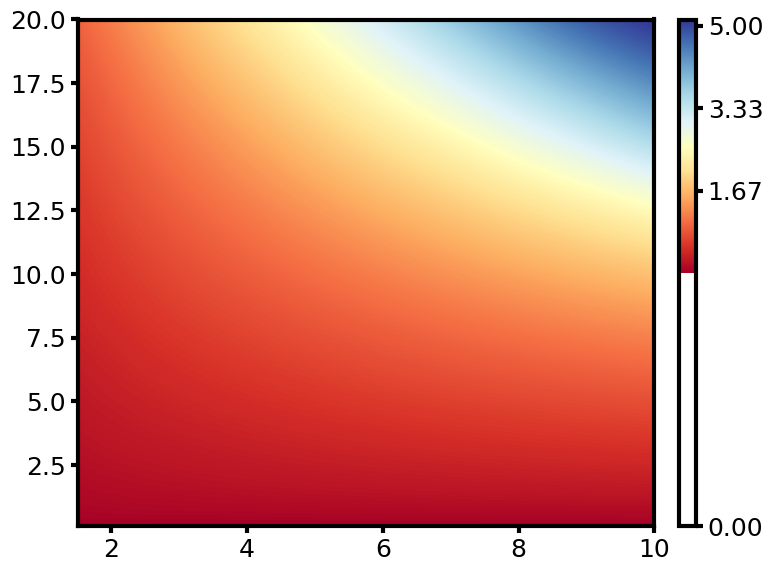

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. 사용자 정의 rc 설정
# -----------------------------
rc = plt.rc
rc('lines', lw=2)
rc('font', size=16)
rc('xtick', labelsize=18)
rc('xtick.major', size=5, width=3)
rc('ytick.major', size=5, width=3)
rc('legend', fontsize=15, frameon=False, loc='best')

# 텍스트(글자) 색상 전체를 검정색으로
plt.rcParams['text.color'] = 'black'
# 축 라벨, 틱, 라벨 등도 검정색
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# 테두리 굵게 설정하는 함수
def bold_figure_edge():
    managers = plt._pylab_helpers.Gcf.get_all_fig_managers()
    for mgr in managers:
        fig = mgr.canvas.figure
        for ax in fig.axes:
            ax.set_frame_on(True)  # 혹시 꺼져있을까봐 켜줌
            for spine in ax.spines.values():
                spine.set_linewidth(3)
                spine.set_color('black')

# (전제) gpr_stress, gpr_strain 학습된 상태라고 가정

# -----------------------------
# 2. 예측용 Grid
# -----------------------------
grid_size = 50
p_grid = np.linspace(1.5, 10, grid_size)        # Particle Size
press_grid = np.linspace(0.1, 20, grid_size)  # Pressure

P_particle, P_pressure = np.meshgrid(p_grid, press_grid)
grid_points = np.column_stack((P_particle.ravel(), P_pressure.ravel()))

stress_pred_grid = gpr_stress.predict(grid_points).reshape(P_particle.shape)
strain_pred_grid = gpr_strain.predict(grid_points).reshape(P_particle.shape)

# -----------------------------
# 3. Stress 그래프
# -----------------------------
masked_stress = np.ma.masked_where(stress_pred_grid > 45, stress_pred_grid)  # 0~45
masked_over   = np.ma.masked_where(stress_pred_grid <= 45, stress_pred_grid) # 45 초과

plt.figure(figsize=(8, 6))

# 격자 비활성화
plt.grid(False)

# X, Y 틱 라벨 설정 (글자 색 검정)
plt.tick_params(axis='x', labelsize=18, labelcolor='black')
plt.tick_params(axis='y', labelsize=18, labelcolor='black')

levels_stress = np.linspace(0, 45, 256)
contourf_stress = plt.contourf(
    P_particle, P_pressure, masked_stress,
    levels=levels_stress,
    cmap='jet',
    extend='neither'
)

cbar_stress = plt.colorbar(
    contourf_stress, orientation='vertical',
    fraction=0.03, pad=0.04, aspect=30
)
# 컬러바 틱, 글자 색 검정
cbar_stress.ax.tick_params(labelsize=18, colors='black')
cbar_stress.set_ticks([0, 15, 30, 45])
cbar_stress.set_ticklabels(["0", "15", "30", "45"])
cbar_stress.outline.set_linewidth(1)

plt.contourf(
    P_particle, P_pressure, masked_over,
    levels=[45, stress_pred_grid.max() + 1],
    colors=['gray'],
    alpha=0
)

# 테두리 굵게 설정 호출!
bold_figure_edge()

plt.savefig("bayesian_optimization_contourf_stress.png", transparent=True)
plt.tight_layout()
plt.show()


# -----------------------------
# 4. Strain 그래프
# -----------------------------
plt.figure(figsize=(8, 6))

# 격자 비활성화
plt.grid(False)

# X, Y 틱 라벨 (글자 색 검정)
plt.tick_params(axis='x', labelsize=18, labelcolor='black')
plt.tick_params(axis='y', labelsize=18, labelcolor='black')

min_strain = strain_pred_grid.min()
max_strain = strain_pred_grid.max()
levels_strain = np.linspace(min_strain, max_strain, 256)

contourf_strain = plt.contourf(
    P_particle, P_pressure, strain_pred_grid,
    levels=levels_strain,
    cmap='RdYlBu',
    extend='neither'
)

cbar_strain = plt.colorbar(
    contourf_strain, orientation='vertical',
    fraction=0.03, pad=0.04, aspect=30
)
# 컬러바 틱, 글자 색 검정
cbar_strain.ax.tick_params(labelsize=18, colors='black')
cbar_strain.set_ticks([0, 1.67, 3.33, 5])
cbar_strain.set_ticklabels(["0.00", "1.67", "3.33", "5.00"])
cbar_strain.outline.set_linewidth(1)

bold_figure_edge()

plt.savefig("bayesian_optimization_contourf_strain.png", transparent=True)
plt.tight_layout()
plt.show()


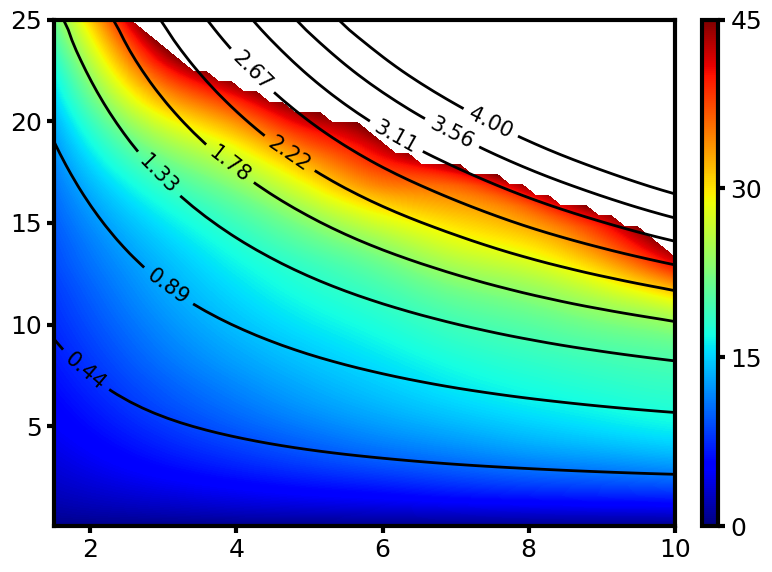

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. 사용자 정의 rc 설정
# -----------------------------
rc = plt.rc
rc('lines', lw=2)
rc('font', size=16)
rc('xtick', labelsize=18)
rc('xtick.major', size=5, width=3)
rc('ytick.major', size=5, width=3)
rc('legend', fontsize=15, frameon=False, loc='best')

# 텍스트(글자) 색상 전체를 검정색으로
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# 테두리 굵게 설정하는 함수
def bold_figure_edge():
    managers = plt._pylab_helpers.Gcf.get_all_fig_managers()
    for mgr in managers:
        fig = mgr.canvas.figure
        for ax in fig.axes:
            ax.set_frame_on(True)
            for spine in ax.spines.values():
                spine.set_linewidth(3)
                spine.set_color('black')


############################################
# (전제) gpr_stress, gpr_strain 등 이미 학습
############################################

# -----------------------------
# 2. 예측용 Grid
# -----------------------------
grid_size = 50
p_grid = np.linspace(1.5, 10, grid_size)     # Particle Size 범위
press_grid = np.linspace(0.1, 25, grid_size) # Pressure 범위

P_particle, P_pressure = np.meshgrid(p_grid, press_grid)
grid_points = np.column_stack((P_particle.ravel(), P_pressure.ravel()))

stress_pred_grid = gpr_stress.predict(grid_points).reshape(P_particle.shape)
strain_pred_grid = gpr_strain.predict(grid_points).reshape(P_particle.shape)

# -----------------------------
# 3. 하나의 그래프에서
#    Stress = 배경 컬러,
#    Strain = 검은색 등고선 (0~4까지만)
# -----------------------------
masked_stress = np.ma.masked_where(stress_pred_grid > 45, stress_pred_grid)  # 0~45
masked_over   = np.ma.masked_where(stress_pred_grid <= 45, stress_pred_grid) # 45 초과

plt.figure(figsize=(8, 6))
plt.grid(False)  # 격자 비활성화
plt.tick_params(axis='x', labelsize=18, labelcolor='black')
plt.tick_params(axis='y', labelsize=18, labelcolor='black')

# (A) Stress = 0~45 범위 jet
levels_stress = np.linspace(0, 45, 256)
contourf_stress = plt.contourf(
    P_particle, P_pressure, masked_stress,
    levels=levels_stress,
    cmap='jet',
    extend='neither'
)

# Colorbar (Stress)
cbar_stress = plt.colorbar(
    contourf_stress,
    orientation='vertical',
    fraction=0.03,
    pad=0.04,
    aspect=30
)
cbar_stress.ax.tick_params(labelsize=18, colors='black')
cbar_stress.set_ticks([0, 15, 30, 45])
cbar_stress.set_ticklabels(["0", "15", "30", "45"])
cbar_stress.outline.set_linewidth(1)

# Stress > 45 영역 (회색)
plt.contourf(
    P_particle, P_pressure, masked_over,
    levels=[45, stress_pred_grid.max() + 1],
    colors=['gray'],
    alpha=0.0
)

# (B) Strain = 검은색 등고선
#     여기서 0 ~ 4 범위만 등고선 표시
contour_strain = plt.contour(
    P_particle, P_pressure, strain_pred_grid,
    levels=np.linspace(0, 4, 10),  # 0부터 4까지 10단계
    colors='k'
)

# 등고선 라벨 표시
plt.clabel(
    contour_strain,
    inline=True,
    fontsize=15,
    fmt="%.2f"
)

# 테두리 굵게
bold_figure_edge()

plt.savefig("bayesian_optimization_stress_strain_combined.png", transparent=True)
plt.tight_layout()
plt.show()


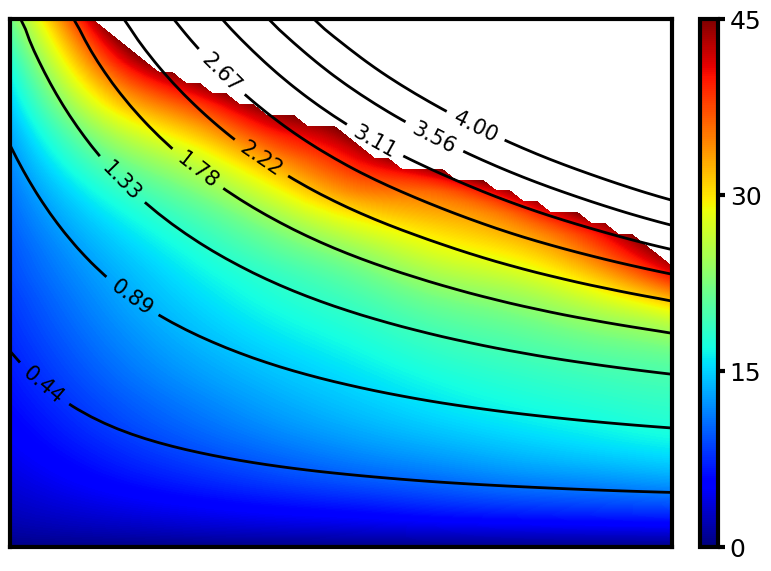

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. 사용자 정의 rc 설정
# -----------------------------
rc = plt.rc
rc('lines', lw=2)
rc('font', size=16)
rc('xtick', labelsize=18)
rc('xtick.major', size=5, width=3)
rc('ytick.major', size=5, width=3)
rc('legend', fontsize=15, frameon=False, loc='best')

# 텍스트(글자) 색상 전체를 검정색으로
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# 테두리 굵게 설정하는 함수
def bold_figure_edge():
    managers = plt._pylab_helpers.Gcf.get_all_fig_managers()
    for mgr in managers:
        fig = mgr.canvas.figure
        for ax in fig.axes:
            ax.set_frame_on(True)
            for spine in ax.spines.values():
                spine.set_linewidth(3)
                spine.set_color('black')


############################################
# (전제) gpr_stress, gpr_strain 등 이미 학습
############################################

# -----------------------------
# 2. 예측용 Grid
# -----------------------------
grid_size = 50
p_grid = np.linspace(1.5, 10, grid_size)     # Particle Size 범위
press_grid = np.linspace(0.1, 25, grid_size) # Pressure 범위

P_particle, P_pressure = np.meshgrid(p_grid, press_grid)
grid_points = np.column_stack((P_particle.ravel(), P_pressure.ravel()))

stress_pred_grid = gpr_stress.predict(grid_points).reshape(P_particle.shape)
strain_pred_grid = gpr_strain.predict(grid_points).reshape(P_particle.shape)

# -----------------------------
# 3. 하나의 그래프에서
#    Stress = 배경 컬러,
#    Strain = 검은색 등고선 (0~4까지만)
# -----------------------------
masked_stress = np.ma.masked_where(stress_pred_grid > 45, stress_pred_grid)  # 0~45
masked_over   = np.ma.masked_where(stress_pred_grid <= 45, stress_pred_grid) # 45 초과

plt.figure(figsize=(8, 6))
plt.grid(False)  # 격자 비활성화
plt.tick_params(axis='x', labelsize=18, labelcolor='black', length=0)  # x축 숫자와 tick 제거
plt.tick_params(axis='y', labelsize=18, labelcolor='black', length=0)  # y축 숫자와 tick 제거

# x, y 축의 숫자 자체를 완전히 없애기
plt.xticks([])  # x축 숫자 제거
plt.yticks([])  # y축 숫자 제거

# (A) Stress = 0~45 범위 jet
levels_stress = np.linspace(0, 45, 256)
contourf_stress = plt.contourf(
    P_particle, P_pressure, masked_stress,
    levels=levels_stress,
    cmap='jet',
    extend='neither'
)

# Colorbar (Stress)
cbar_stress = plt.colorbar(
    contourf_stress,
    orientation='vertical',
    fraction=0.03,
    pad=0.04,
    aspect=30
)
cbar_stress.ax.tick_params(labelsize=18, colors='black')
cbar_stress.set_ticks([0, 15, 30, 45])
cbar_stress.set_ticklabels(["0", "15", "30", "45"])
cbar_stress.outline.set_linewidth(1)

# Stress > 45 영역 (회색)
plt.contourf(
    P_particle, P_pressure, masked_over,
    levels=[45, stress_pred_grid.max() + 1],
    colors=['gray'],
    alpha=0.0
)

# (B) Strain = 검은색 등고선
#     여기서 0 ~ 4 범위만 등고선 표시
contour_strain = plt.contour(
    P_particle, P_pressure, strain_pred_grid,
    levels=np.linspace(0, 4, 10),  # 0부터 4까지 10단계
    colors='k'
)

# 등고선 라벨 표시
plt.clabel(
    contour_strain,
    inline=True,
    fontsize=15,
    fmt="%.2f"
)

# 테두리 굵게
bold_figure_edge()

plt.savefig("bayesian_optimization_scheme.png", transparent=True)
plt.tight_layout()
plt.show()


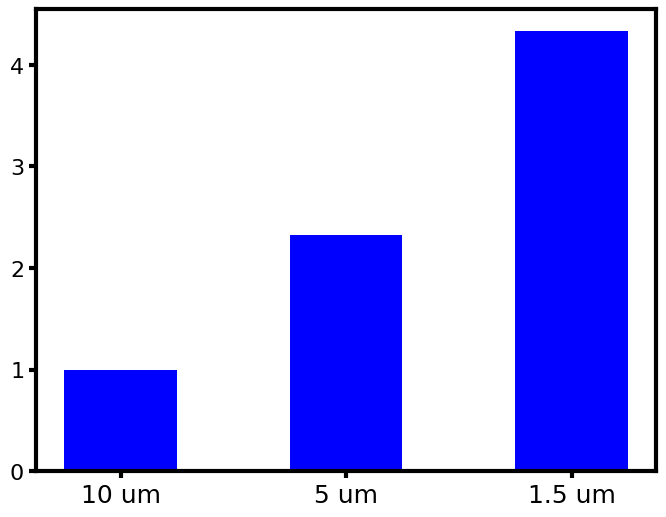

In [19]:
import matplotlib.pyplot as plt

# -----------------------------
# 1. 사용자 정의 rc 설정
# -----------------------------
rc = plt.rc
rc('lines', lw=2)
rc('font', size=16)
rc('xtick', labelsize=18)
rc('xtick.major', size=5, width=3)
rc('ytick.major', size=5, width=3)
rc('legend', fontsize=15, frameon=False, loc='best')

# 텍스트(글자) 색상 전체를 검정색으로
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# 테두리 굵게 설정하는 함수
def bold_figure_edge():
    managers = plt._pylab_helpers.Gcf.get_all_fig_managers()
    for mgr in managers:
        fig = mgr.canvas.figure
        for ax in fig.axes:
            ax.set_frame_on(True)
            for spine in ax.spines.values():
                spine.set_linewidth(3)
                spine.set_color('black')


# 데이터 포인트
Strain = [1.000036536, 2.319715534, 4.330091185]
plt.figure(figsize=(8, 6))
# x축에 표시할 이름 설정
x_labels = ['10 um', '5 um', '1.5 um']  # 원하는 이름으로 수정

# 막대그래프 그리기
plt.bar(range(len(Strain)), Strain, color='b', width=0.5)

# x축 tick 설정
plt.xticks(range(len(Strain)), x_labels)

# 축 레이블 설정
#plt.xlabel('Sample')
#plt.ylabel('Strain Value')
#plt.title('Strain Bar Graph')

# 그래프 출력

#plt.grid(axis='y')
bold_figure_edge()
plt.show()


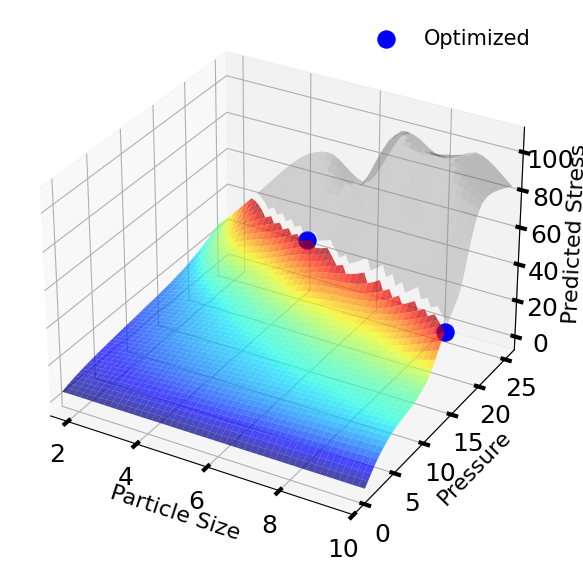

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel

# Adjustable Parameters
marker_size = 150  # Size of scatter plot markers
line_width = 3  # Width of lines in plots

# Step 1: Generate grid points for 3D surface
particle_sizes = np.linspace(1.5, 10, 50)
pressures = np.linspace(0.1, 25, 50)
P_particle, P_pressure = np.meshgrid(particle_sizes, pressures)
grid_points = np.column_stack((P_particle.ravel(), P_pressure.ravel()))

# Step 2: Predict stress values
stress_pred_grid = gpr_stress.predict(grid_points).reshape(P_particle.shape)

# Step 3: Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Mask values greater than 45 for gray representation
masked_stress = np.ma.masked_where(stress_pred_grid > 45, stress_pred_grid)
masked_over = np.ma.masked_where(stress_pred_grid <= 45, stress_pred_grid)

# Plot stress values within range 0-45
ax.plot_surface(P_particle, P_pressure, masked_stress, cmap='jet', alpha=0.7, edgecolor='none')

# Plot stress values above 45 as gray
ax.plot_surface(P_particle, P_pressure, masked_over, color='gray', alpha=0.3, edgecolor='none')

# Step 4: Plot optimized points only for 5 um and 10 um
for ps in [5, 10]:
    best_pr = None
    best_val = None
    for pr in pressures:
        pred_val = gpr_stress.predict([[ps, pr]])[0]
        if pred_val < 45:  # Constraint condition
            if best_val is None or pred_val > best_val:
                best_val = pred_val
                best_pr = pr
    if best_pr is not None:
        opt_stress = gpr_stress.predict([[ps, best_pr]])[0]
        ax.scatter(ps, best_pr, opt_stress, color='b', s=marker_size, label='Optimized' if ps == 5 else "")

# Step 5: Labels and formatting
ax.set_xlabel('Particle Size')
ax.set_xlim(1.5, 10)
ax.set_ylabel('Pressure')
ax.set_zlabel('Predicted Stress')
ax.view_init(elev=30, azim=-60)  # Set 3D view angle
plt.legend()

# Save and show plot
plt.savefig("optimization_surface_stress.png", transparent=True, dpi=300)
plt.show()


## Bimodal

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import random
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

#############################################
# 고정된 시드 설정 (재현성 확보)
#############################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

#############################################
# 1. 데이터 정의 - 상황에 맞게 설정가능합니다.
#    (particle_size, pressure) 2차원 조합
#############################################
particle_sizes = [10, 9, 8, 6, 5, 3, 1.5]  # 9 개 
pressures = [0.1, 0.3, 0.5, 0.7, 0.9, 1, 2, 3, 4, 5,
             6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
             16, 17, 18, 19, 20] #30 개

# X_list에 모든 (ps, pr) 조합을 순서대로 저장
X_list = []
for ps in particle_sizes:
    for pr in pressures:
        X_list.append((ps, pr))

# numpy 배열로 변환 -> shape = (270, 2)
X_train = np.array(X_list)

# 이제 X_train[i] = (particle_size, pressure)에 대응하는
# stress, strain 데이터를 준비해야 함 (길이: 9 X 30 = 270).

true_stress = [0.42395,
1.3172,
2.2183,
3.1395,
4.0532,
4.5485,
8.8582,
12.108,
14.62,
16.46,
17.736,
18.629,
19.662,
21.146,
23.647,
27.479,
33.616,
40.502,
46.2,
51.445,
57.572,
70.516,
83.191,
91.036,
93.565,
#,,
0.38073,
1.1765,
2.0313,
2.9061,
3.7933,
4.2325,
8.3285,
11.714,
14.2,
16.031,
17.424,
18.521,
19.533,
20.556,
22.396,
26.062,
32.356,
41.281,
50.597,
57.92,
61.978,
62.213,
59.933,
55.873,
52.621,
0.38215,
1.1834,
2.0345,
2.8956,
3.7467,
4.1737,
8.1163,
11.335,
13.799,
15.742,
17.289,
18.701,
19.977,
21.172,
22.838,
26.078,
31.643,
39.523,
48.334,
55.986,
61.791,
65.252,
66.501,
66.766,
67.611,
0.45751,
1.4117,
2.3652,
3.3799,
4.1711,
4.5846,
8.3336,
11.15,
13.225,
14.733,
15.972,
17.107,
18.42,
19.967,
22.143,
25.384,
29.948,
35.406,
40.784,
46.85,
57.685,
71.056,
80.402,
82.771,
80.445,
0.49484,
1.5268,
2.5951,
3.5449,
4.4613,
4.8946,
8.8454,
11.753,
13.779,
15.265,
16.464,
17.839,
19.374,
21.401,
24.586,
29.274,
35.191,
40.86,
47.645,
60.232,
73.77,
81.821,
82.049,
78.48,
74.525,
0.43641,
1.3451,
2.257,
3.3665,
3.9836,
4.4256,
8.0421,
10.839,
12.912,
14.437,
15.626,
16.697,
17.935,
19.318,
21.018,
23.565,
27.22,
32.152,
37.423,
42.487,
49.075,
60.673,
73.157,
81.065,
82.541,
0.30471,
0.94185,
1.6157,
2.2214,
2.9779,
3.1644,
5.9158,
8.383,
10.373,
11.983,
13.272,
14.378,
15.229,
16.025,
16.702,
15.874,
16.484,
17.179,
17.668,
18.619,
19.392,
20.315,
21.424,
22.667,
24.635
]


true_strain = [0.017925,
0.055025,
0.092575,
0.1299,
0.16615,
0.183775,
0.3472,
0.495375,
0.63895,
0.78445,
0.9379,
1.10445,
1.28925,
1.49745,
1.73625,
2.0115,
2.329,
2.6875,
3.071,
3.46075,
3.841,
4.2085,
4.558,
4.8665,
5.12425,
#
0.017975,
0.0557,
0.093825,
0.131475,
0.167675,
0.185375,
0.347525,
0.49405,
0.6356,
0.7789,
0.929075,
1.090525,
1.268,
1.4661,
1.68775,
1.9375,
2.2165,
2.529,
2.874,
3.24325,
3.6245,
4.00025,
4.35975,
4.68875,
4.97725,
0.016775,
0.053625,
0.09095,
0.1276,
0.163125,
0.180425,
0.33855,
0.480375,
0.61785,
0.75625,
0.900575,
1.055,
1.223525,
1.410825,
1.62025,
1.85375,
2.115,
2.4065,
2.728,
3.074,
3.43375,
3.795,
4.14375,
4.46925,
4.7585,
0.0195,
0.06065,
0.10185,
0.141383333,
0.178866667,
0.196866667,
0.35655,
0.500266667,
0.6393,
0.781,
0.930666667,
1.092333333,
1.270666667,
1.469833333,
1.696,
1.954,
2.244666667,
2.560333333,
2.8855,
3.213833333,
3.548833333,
3.893833333,
4.241166667,
4.588166667,
4.922833333,
0.021083333,
0.065583333,
0.109816667,
0.151916667,
0.1917,
0.210616667,
0.379983333,
0.533383333,
0.683666667,
0.839,
1.005333333,
1.1885,
1.393833333,
1.6275,
1.897166667,
2.2045,
2.542833333,
2.893,
3.2495,
3.611333333,
3.983666667,
4.360666667,
4.730666667,
5.084333333,
5.415666667,
0.018583333,
0.057783333,
0.0972,
0.135266667,
0.17135,
0.188833333,
0.342783333,
0.481033333,
0.6139,
0.748166667,
0.888666667,
1.039166667,
1.2035,
1.385666667,
1.59,
1.820666667,
2.082333333,
2.371166667,
2.676833333,
2.988833333,
3.303166667,
3.626,
3.9555,
4.288666667,
4.619,
0.012966667,
0.040233333,
0.068233333,
0.095883333,
0.123033333,
0.136083333,
0.254966667,
0.358466667,
0.4561,
0.550283333,
0.6437,
0.738666667,
0.8365,
0.9385,
1.045833333,
0.921333333,
1.0065,
1.096,
1.19,
1.2905,
1.395833333,
1.509166667,
1.631166667,
1.761,
1.901
]

y_stress_train = np.array(true_stress)
y_strain_train = np.array(true_strain)

print(f"X_train shape: {X_train.shape}")         # (150, 2)
print(f"y_stress_train shape: {y_stress_train.shape}")   # (150,)
print(f"y_strain_train shape: {y_strain_train.shape}")   # (150,)

#############################################
# 2. Gaussian Process 모델 설정 & 학습
#############################################
kernel = C(1.0, (1e-3, 1e5)) * Matern(length_scale=5.0, nu=1.0) + WhiteKernel(noise_level=1e-5)

gpr_stress = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10,
    random_state=SEED
)
gpr_strain = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10,
    random_state=SEED
)

# 모델 학습
gpr_stress.fit(X_train, y_stress_train)
gpr_strain.fit(X_train, y_strain_train)

#############################################
# 3. 모델 평가 함수
#############################################
def evaluate_model(gp_model, X, y_true):
    y_pred, y_std = gp_model.predict(X, return_std=True)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2, y_pred, y_std

# (선택) 훈련 데이터에 대한 적합도 확인
stress_mse_train, stress_mae_train, stress_r2_train, stress_pred_train, stress_std_train = evaluate_model(
    gpr_stress, X_train, y_stress_train
)
strain_mse_train, strain_mae_train, strain_r2_train, strain_pred_train, strain_std_train = evaluate_model(
    gpr_strain, X_train, y_strain_train
)

print("========== GPR Model Performance on Training Data ==========")
print(f"Stress - R²: {stress_r2_train:.3f}, MSE: {stress_mse_train:.3f}, MAE: {stress_mae_train:.3f}")
print(f"Strain - R²: {strain_r2_train:.3f}, MSE: {strain_mse_train:.3f}, MAE: {strain_mae_train:.3f}")

#############################################
# 4. Bayesian Optimization
#    - 목적함수에서 Stress, Strain 모두 고려
#    - 제약(Stress < 45, Strain < 4) 위반 시 페널티
#############################################
def objective_function(particle_size, pressure):
    # 예측
    stress_pred = gpr_stress.predict([[particle_size, pressure]])[0]
    strain_pred = gpr_strain.predict([[particle_size, pressure]])[0]
    
    # 제약 조건
    penalty = 0.0
    if stress_pred >= 45:
        penalty -= 100.0 * (stress_pred - 45)
    if strain_pred >= 4:
        penalty -= 100.0 * (strain_pred - 4)
    
    # (예시) 목표: particle_size + pressure + penalty 최댓값
    base_value = particle_size + pressure
    return base_value + penalty

# 탐색 범위
pbounds = {
    'particle_size': (6, 20),  # 실제 particle_sizes 범위
    'pressure': (0.1, 25)     # 실제 pressures 범위
}

optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=random.randint(1, 1000)
)

optimizer.maximize(init_points=10, n_iter=30)

opt_params = optimizer.max['params']
optimal_particle_size = opt_params['particle_size']
optimal_pressure = opt_params['pressure']
optimal_value = optimizer.max['target']

# 최적해에서 Stress, Strain 예측
opt_stress = gpr_stress.predict([[optimal_particle_size, optimal_pressure]])[0]
opt_strain = gpr_strain.predict([[optimal_particle_size, optimal_pressure]])[0]

print("\n===== Optimization Result =====")
print(f"Optimal Particle Size: {optimal_particle_size:.4f}")
print(f"Optimal Pressure: {optimal_pressure:.4f}")
print(f"Optimal Objective Value: {optimal_value:.4f}")
print(f"Predicted Stress at Opt: {opt_stress:.4f}")
print(f"Predicted Strain at Opt: {opt_strain:.4f}")

#############################################
# 5. 각 Particle Size별로 
#    Pressure를 (0.1~25) 범위 세분화 → 제약 만족 + objective 최대 지점
#############################################
particle_size_candidates = [1.5, 5, 10, 15, 20 ]
pressure_candidates = np.linspace(0.1, 25, 300)  # 예: 300개로 분할 샘플링

print("\n===== Per Particle Size: Best Pressure under Constraints =====")
for ps in particle_size_candidates:
    best_objective = None
    best_pressure = None
    for pr in pressure_candidates:
        # 예측
        st = gpr_stress.predict([[ps, pr]])[0]
        stn = gpr_strain.predict([[ps, pr]])[0]
        # 제약조건 확인
        if (st < 45) and (stn < 4):
            # objective
            obj_val = objective_function(ps, pr)
            # 갱신
            if (best_objective is None) or (obj_val > best_objective):
                best_objective = obj_val
                best_pressure = pr
    
    if best_pressure is None:
        print(f"Particle Size={ps}: No feasible Pressure found (Constraints not satisfied).")
    else:
        # 최적해에서 Stress, Strain 확인
        st_opt = gpr_stress.predict([[ps, best_pressure]])[0]
        stn_opt = gpr_strain.predict([[ps, best_pressure]])[0]
        print(f"Particle Size={ps}")
        print(f"   Best Pressure={best_pressure:.4f}, Objective={best_objective:.4f}")
        print(f"   Stress={st_opt:.4f}, Strain={stn_opt:.4f}")


X_train shape: (175, 2)
y_stress_train shape: (175,)
y_strain_train shape: (175,)
========== GPR Model Performance on Training Data ==========
Stress - R²: 1.000, MSE: 0.000, MAE: 0.000
Strain - R²: 1.000, MSE: 0.000, MAE: 0.000
|   iter    |  target   | partic... | pressure  |
-------------------------------------------------
| 1         | -1.66e+03 | 8.801     | 17.22     |
| 2         | 22.64     | 19.07     | 3.57      |
| 3         | -2.699e+0 | 7.71      | 20.72     |
| 4         | -8.115e+0 | 19.01     | 18.69     |
| 5         | 20.51     | 12.92     | 7.588     |
| 6         | 16.95     | 9.904     | 7.05      |
| 7         | -4.822e+0 | 19.54     | 14.63     |
| 8         | -1.258e+0 | 17.48     | 10.89     |
| 9         | 19.1      | 6.058     | 13.04     |
| 10        | 10.45     | 6.106     | 4.343     |
| 11        | 12.46     | 12.27     | 0.1897    |
| 12        | 6.337     | 6.235     | 0.1028    |
| 13        | 20.08     | 19.97     | 0.1113    |
| 14        | 15.43  

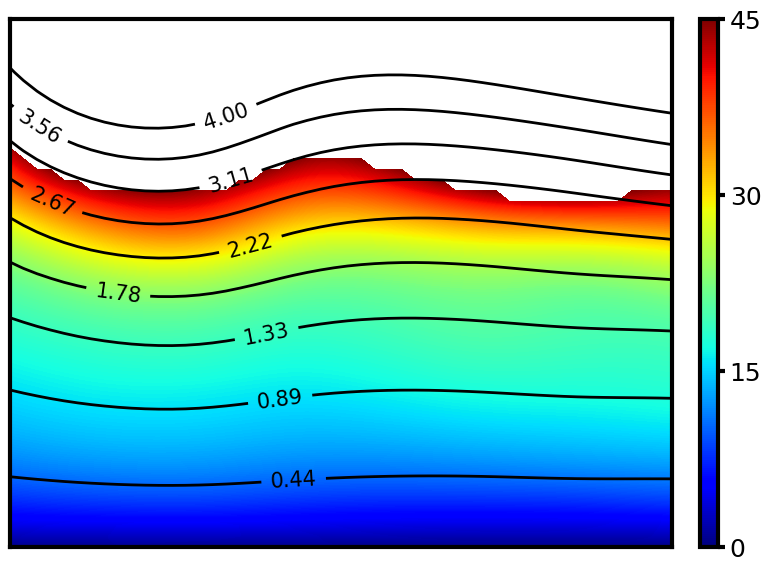

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. 사용자 정의 rc 설정
# -----------------------------
rc = plt.rc
rc('lines', lw=2)
rc('font', size=16)
rc('xtick', labelsize=18)
rc('xtick.major', size=5, width=3)
rc('ytick.major', size=5, width=3)
rc('legend', fontsize=15, frameon=False, loc='best')

# 텍스트(글자) 색상 전체를 검정색으로
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# 테두리 굵게 설정하는 함수
def bold_figure_edge():
    managers = plt._pylab_helpers.Gcf.get_all_fig_managers()
    for mgr in managers:
        fig = mgr.canvas.figure
        for ax in fig.axes:
            ax.set_frame_on(True)
            for spine in ax.spines.values():
                spine.set_linewidth(3)
                spine.set_color('black')


############################################
# (전제) gpr_stress, gpr_strain 등 이미 학습
############################################

# -----------------------------
# 2. 예측용 Grid
# -----------------------------
grid_size = 50
p_grid = np.linspace(3, 10, grid_size)     # Particle Size 범위
press_grid = np.linspace(0.1, 20, grid_size) # Pressure 범위

P_particle, P_pressure = np.meshgrid(p_grid, press_grid)
grid_points = np.column_stack((P_particle.ravel(), P_pressure.ravel()))

stress_pred_grid = gpr_stress.predict(grid_points).reshape(P_particle.shape)
strain_pred_grid = gpr_strain.predict(grid_points).reshape(P_particle.shape)

# -----------------------------
# 3. 하나의 그래프에서
#    Stress = 배경 컬러,
#    Strain = 검은색 등고선 (0~4까지만)
# -----------------------------
masked_stress = np.ma.masked_where(stress_pred_grid > 45, stress_pred_grid)  # 0~45
masked_over   = np.ma.masked_where(stress_pred_grid <= 45, stress_pred_grid) # 45 초과

plt.figure(figsize=(8, 6))
plt.grid(False)  # 격자 비활성화
plt.tick_params(axis='x', labelsize=18, labelcolor='black', length=0)  # x축 숫자와 tick 제거
plt.tick_params(axis='y', labelsize=18, labelcolor='black', length=0)  # y축 숫자와 tick 제거

# x, y 축의 숫자 자체를 완전히 없애기
plt.xticks([])  # x축 숫자 제거
plt.yticks([])  # y축 숫자 제거

# (A) Stress = 0~45 범위 jet
levels_stress = np.linspace(0, 45, 256)
contourf_stress = plt.contourf(
    P_particle, P_pressure, masked_stress,
    levels=levels_stress,
    cmap='jet',
    extend='neither'
)

# Colorbar (Stress)
cbar_stress = plt.colorbar(
    contourf_stress,
    orientation='vertical',
    fraction=0.03,
    pad=0.04,
    aspect=30
)
cbar_stress.ax.tick_params(labelsize=18, colors='black')
cbar_stress.set_ticks([0, 15, 30, 45])
cbar_stress.set_ticklabels(["0", "15", "30", "45"])
cbar_stress.outline.set_linewidth(1)

# Stress > 45 영역 (회색)
plt.contourf(
    P_particle, P_pressure, masked_over,
    levels=[45, stress_pred_grid.max() + 1],
    colors=['gray'],
    alpha=0.0
)

# (B) Strain = 검은색 등고선
#     여기서 0 ~ 4 범위만 등고선 표시
contour_strain = plt.contour(
    P_particle, P_pressure, strain_pred_grid,
    levels=np.linspace(0, 4, 10),  # 0부터 4까지 10단계
    colors='k'
)

# 등고선 라벨 표시
plt.clabel(
    contour_strain,
    inline=True,
    fontsize=15,
    fmt="%.2f"
)

# 테두리 굵게
bold_figure_edge()

plt.savefig("bayesian_optimization_bimodal.png", transparent=True)
plt.tight_layout()
plt.show()
